In [1]:
import ROOT
from ROOT import TMath
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
import os

Welcome to JupyROOT 6.26/02


In [2]:

'''Importing the data from the ROOT files'''

data4 = ROOT.TFile.Open("data_D.GamGam.root")

Channels = {'data4':data4.Get('mini')}

for channel in Channels:
    print("Channel:",channel,"has",Channels[channel].GetEntries(),"entries")

OutputMap = {"ttH":[1,0,0,0],"ggH":[0,1,0,0],"WWH":[0,0,1,0], 
             'data1':[0,0,0,1], 'data2':[0,0,0,1], 'data3':[0,0,0,1], 'data4':[0,0,0,1]}

# Here we shall store the two photons & outputs 
dataset = []
dataset2 = []

# Prepare Data for NN
# Events are not filtered by LLT or HLT

for channel in Channels:
    print("Processing Channel ",channel)
    Channel = Channels[channel]
    counter = 0
    for event in Channel:
        #if (not event.trigP):
            #continue
        if counter > 200000:
            break
        Photons = []
        if Channel.photon_n != 2:
            continue
        for j in range(Channel.photon_n):
            Momentum = ROOT.TLorentzVector()
            Momentum.SetPtEtaPhiE(Channel.photon_pt[j]/1000., Channel.photon_eta[j],Channel.photon_phi[j],Channel.photon_E[j]/1000.)
            Photons.append(Momentum)
        Photons.sort(key = lambda p : -p.E())#sorts by energy most energetic goes first
        data = []
        data2 = []
        data2.append(np.sqrt(2*(Photons[0].E()*Photons[1].E()-Photons[0].Px()*Photons[1].Px()-Photons[0].Py()*Photons[1].Py()-Photons[0].Pz()*Photons[1].Pz())))
        for i in range(len(Photons)):
            #momentum of the photons go into nn
            data.append(Photons[i].E() )
            data.append(Photons[i].Px())
            data.append(Photons[i].Py())
            data.append(Photons[i].Pz())
            data2.append(Photons[i].Px())
            data2.append(Photons[i].Py())
            data2.append(Photons[i].Pz())
        for vec in OutputMap[channel]:
            data.append(vec)
            data2.append(vec)
        dataset.append(data)
        dataset2.append(data2)
        counter += 1
        
        
random.shuffle(dataset)
dataset = np.asarray(dataset)

random.shuffle(dataset2)
dataset2 = np.asarray(dataset2)

Channel: data4 has 3602176 entries
Processing Channel  data4


In [46]:
'''Importing the data from the ROOT files'''

ttH = ROOT.TFile.Open("mc_341081.ttH125_gamgam.GamGam.root")
ggH = ROOT.TFile.Open("mc_343981.ggH125_gamgam.GamGam.root")
WWH = ROOT.TFile.Open("mc_345041.VBFH125_gamgam.GamGam.root")
data1 = ROOT.TFile.Open("data_A.GamGam.root")
data3 = ROOT.TFile.Open("data_C.GamGam.root")
data4 = ROOT.TFile.Open("data_D.GamGam.root")

Channels2 = {"ttH":ttH.Get("mini"),
            "ggH":ggH.Get("mini"),
            "WWH":WWH.Get("mini"), 
            'data1':data1.Get('mini'), 
            'data3':data3.Get('mini'),
            'data4':data4.Get('mini')
           }

for channel in Channels2:
    print("Channel:",channel,"has",Channels2[channel].GetEntries(),"entries")

OutputMap = {"ttH":[1,0,0,0],"ggH":[0,1,0,0],"WWH":[0,0,1,0], 
             'data1':[0,0,0,1], 'data2':[0,0,0,1], 'data3':[0,0,0,1], 'data4':[0,0,0,1]}

# Here we shall store the two photons & outputs 
new_dataset = []
new_dataset2 = []

# Prepare Data for NN
# Events are not filtered by LLT or HLT

for channel in Channels2:
    print("Processing Channel ",channel)
    Channel = Channels2[channel]
    counter = 0
    for event in Channel:
        #if (not event.trigP):
            #continue
        if counter > 200000:
            break
        Photons = []
        if Channel.photon_n != 2:
            continue
        for j in range(Channel.photon_n):
            Momentum = ROOT.TLorentzVector()
            Momentum.SetPtEtaPhiE(Channel.photon_pt[j]/1000., Channel.photon_eta[j],Channel.photon_phi[j],Channel.photon_E[j]/1000.)
            Photons.append(Momentum)
        Photons.sort(key = lambda p : -p.E())#sorts by energy most energetic goes first
        data = []
        data2 = []
        data2.append(np.sqrt(2*(Photons[0].E()*Photons[1].E()-Photons[0].Px()*Photons[1].Px()-Photons[0].Py()*Photons[1].Py()-Photons[0].Pz()*Photons[1].Pz())))
        for i in range(len(Photons)):
            #momentum of the photons go into nn
            data.append(Photons[i].E() )
            data.append(Photons[i].Px())
            data.append(Photons[i].Py())
            data.append(Photons[i].Pz())
            data2.append(Photons[i].Px())
            data2.append(Photons[i].Py())
            data2.append(Photons[i].Pz())
        for vec in OutputMap[channel]:
            data.append(vec)
            data2.append(vec)
        new_dataset.append(data)
        new_dataset2.append(data2)
        counter += 1
        
        
random.shuffle(new_dataset)
new_dataset = np.asarray(new_dataset)

random.shuffle(new_dataset2)
new_dataset2 = np.asarray(new_dataset2)

Channel: ttH has 576491 entries
Channel: ggH has 1054711 entries
Channel: WWH has 497468 entries
Channel: data1 has 430344 entries
Channel: data3 has 2237187 entries
Channel: data4 has 3602176 entries
Processing Channel  ttH
Processing Channel  ggH
Processing Channel  WWH
Processing Channel  data1
Processing Channel  data3
Processing Channel  data4


In [31]:
def create_proc_model():
    ilayer = layers.Dense(units = 7, input_dim = len(dataset2[0,:-4]), activation="relu")
    layer1 = layers.Dense(units = 8, activation="relu")
    layer2 = layers.Dense(units = 9, activation="relu")
    olayer = layers.Dense(units = 4, activation = "sigmoid")

    Model = keras.Sequential([ilayer,layer1,layer2,olayer])
    
    Model.compile(
    optimizer = keras.optimizers.SGD(0.001),
    loss="binary_crossentropy"
    )
    
    return Model

In [32]:
def create_nonproc_model():
    ilayer = layers.Dense(units = 7, input_dim = len(dataset[0,:-4]), activation="relu")
    layer1 = layers.Dense(units = 8, activation="relu")
    layer2 = layers.Dense(units = 9, activation="relu")
    olayer = layers.Dense(units = 4, activation = "sigmoid")

    Model = keras.Sequential([ilayer,layer1,layer2,olayer])
    
    Model.compile(
    optimizer = keras.optimizers.SGD(0.001),
    loss="binary_crossentropy"
    )
    
    return Model

In [34]:
modelfolder = '/Users/dan-ioanbultoc/Desktop/EE/non-processed_weights/'
nonproc_model = create_nonproc_model()
nonproc_model.load_weights(modelfolder)

modelfolder2 = '/Users/dan-ioanbultoc/Desktop/EE/processed_weights/'
proc_model = create_proc_model()
proc_model.load_weights(modelfolder2)

In [41]:
x = dataset[:,:-4]
y = dataset2[:,:-4]

nonproc = nonproc_model.predict(x)
proc = proc_model.predict(y)

In [47]:
a = new_dataset[:,:-4]
b = new_dataset2[:,:-4]

new_nonproc = nonproc_model.predict(a)
new_proc = proc_model.predict(b)

In [50]:
a_answer = new_dataset[:,-4:]
b_answer = new_dataset2[:,-4:]

print(new_nonproc[0])
print(a_answer[0])

[0.06183913 0.02443975 0.06537494 0.8702694 ]
[0. 0. 0. 1.]


In [18]:
def prob(arr):
    return (arr[0] + arr[1] + arr[2])/sum(arr)

In [22]:
print(nonproc[0][3]+prob(nonproc[0]))

0.9985697144218834


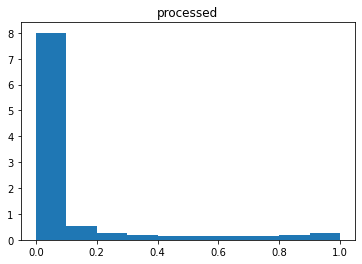

In [38]:
proc_values = []

for i in range(len(proc)):
    proc_values.append(prob(proc[i]))

plt.clf()
plt.title('processed')
plt.hist(proc_values, density = True)
plt.show()

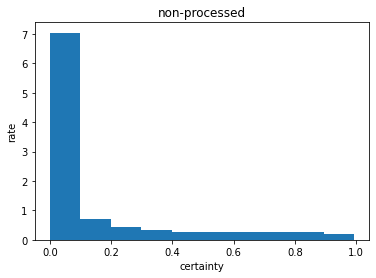

In [61]:
nonproc_values = []

for i in range(len(nonproc)):
    nonproc_values.append(prob(nonproc[i]))

plt.clf()
plt.title('non-processed')
plt.xlabel('certainty')
plt.ylabel('rate')
plt.hist(nonproc_values, density = True)
plt.show()

In [62]:
def rate(certainty, prediction):
    rates = []
    for i in range(len(certainty)):
        var = 0
        for j in range(len(prediction)):
            if prob(prediction[j]) > certainty[i]:
                var += 1
            
        var /= len(prediction)
        rates.append(var)
    return rates

In [ ]:
non-training
pre-training2

In [51]:
certainty = [0.05*i for i in range(1,20)]
eff = []

for i in range(len(certainty)):
    efficiency = 0
    for j in range(len(new_nonproc)):
        if prob(new_nonproc[j]) > certainty[i] and a_answer[j][-1] == 0:
            efficiency += 1
            
        if prob(new_nonproc[j]) < certainty[i] and a_answer[j][-1] == 1:
            efficiency += 1
                  
    efficiency /= len(new_nonproc)
    eff.append(efficiency)

In [70]:
certainty = [0.05*i for i in range(1,21)]

def compute_eff(certainty, prediction, answer, title):
    
    eff = []
    
    for i in range(len(certainty)):
        print(certainty[i])
        efficiency = 0
        for j in range(len(prediction)):
            if prob(prediction[j]) > certainty[i] and answer[j][-1] == 0:
                efficiency += 1

            if prob(prediction[j]) < certainty[i] and answer[j][-1] == 1:
                efficiency += 1

        efficiency /= len(prediction)
        eff.append(efficiency)
        
    plt.clf()
    plt.plot(certainty, eff)
    plt.title(title)
    plt.xlabel('certainty')
    plt.ylabel('efficiency')
    plt.show()
    
    return eff

0.05
0.1
0.15000000000000002
0.2
0.25
0.30000000000000004
0.35000000000000003
0.4
0.45
0.5
0.55
0.6000000000000001
0.65
0.7000000000000001
0.75
0.8
0.8500000000000001
0.9
0.9500000000000001


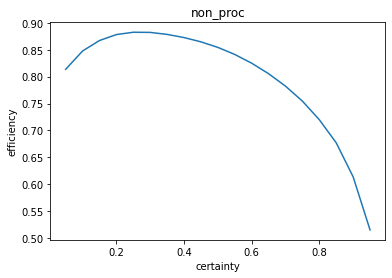

0.05
0.1
0.15000000000000002
0.2
0.25
0.30000000000000004
0.35000000000000003
0.4
0.45
0.5
0.55
0.6000000000000001
0.65
0.7000000000000001
0.75
0.8
0.8500000000000001
0.9
0.9500000000000001


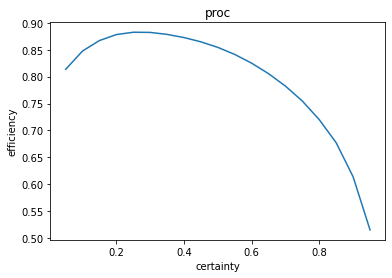

In [71]:
nonproc_eff = compute_eff(certainty, new_nonproc, a_answer, 'non_proc')
proc_eff = compute_eff(certainty, new_nonproc, a_answer, 'proc')

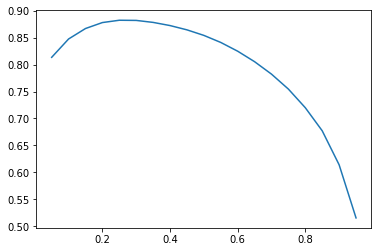

In [59]:
plt.clf()
plt.plot(certainty, eff)
plt.xlabel('certainty')
plt.ylabel('efficiency')
plt.show()

In [74]:
nonproc_rate = rate(certainty, nonproc)
proc_rate = rate(certainty, proc)

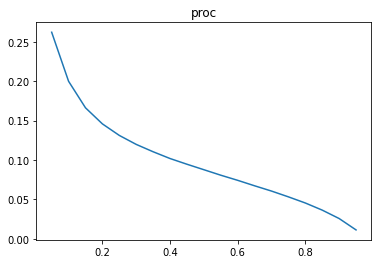

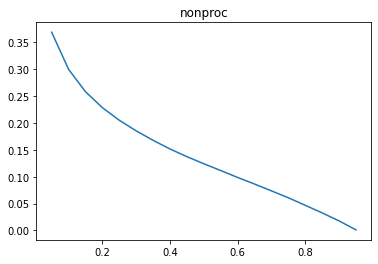

In [76]:
plt.clf()
plt.plot(certainty, proc_rate)
plt.title('proc')
plt.show()

plt.clf()
plt.title('nonproc')
plt.plot(certainty, nonproc_rate)
plt.show()

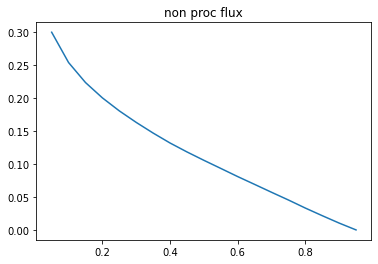

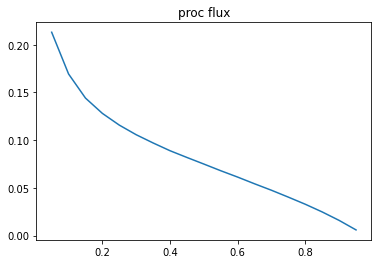

In [75]:
non_proc_flux = [nonproc_rate[i]*eff[i] for i in range(len(certainty))]
proc_flux = [proc_rate[i]* eff[i] for i in range(len(certainty))]

plt.clf()
plt.plot(certainty, non_proc_flux)
plt.title('non proc flux')
plt.show()

plt.clf()
plt.plot(certainty, proc_flux)
plt.title('proc flux')
plt.show()